<a href="https://colab.research.google.com/github/Qiustander/Simple_MCMC_tasks/blob/main/MCMC_For_Multivariate_Normal_Distribution_with_Gibbs_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>.
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
In summary, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [ ]:
#@title Imports and Global Variables  { display-mode: "form" }
"""Import necessary packages and set global variables
"""
!pip3 install -q pandas_datareader
!pip3 install -q wget
!pip3 install statsmodels
from __future__ import absolute_import, division, print_function

import numpy as np
import os
import statsmodels.api as sm
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def credible_interval(posterior_dist, alpha=0.05):
    """
    Compute the credible interval for a set of samples.

    Parameters:
    - posterior_dist: array-like, the set of samples
    - alpha: float, desired significance level (e.g., 0.05 for 95% credible interval)

    Returns:
    - tuple containing the lower and upper bounds of the credible interval
    """
    sorted_samples = np.sort(posterior_dist)
    lower_bound = np.percentile(sorted_samples, 100 * alpha / 2)
    upper_bound = np.percentile(sorted_samples, 100 * (1 - alpha / 2))

    return (lower_bound, upper_bound)


from tensorflow_probability.python.mcmc import RandomWalkMetropolis
from tensorflow_probability.python.mcmc import HamiltonianMonteCarlo
from tensorflow_probability.python.mcmc import sample_chain
from tensorflow_probability.python.internal import prefer_static as ps

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')


  Preparing metadata (setup.py) ... done
TnesorFlow version: 2.12.0
TnesorFlow Probability version: 0.20.1


# MCMC For Fitting 3D Normal Distribution

We have $N$ points observed data: $p(\mathbf{x_i}|\mathbf{\mu}, \Sigma)\in \mathbb{R}^N \sim \mathcal{N}(\mathbf{\mu}, \Sigma), i = 1, \dots, N$, where $\mu \in \mathbb{R}^N$ or $σ^2 \in \mathbb{R}_+^{N \times N}$ maybe unknown. $\mathbf{x_i}$ denotes $n$-th data sample.

Problem: estimate $p(\mu|\mathbf{x},\Sigma) ∝ \pi(\mu)l(\mathbf{x}|\mu, \Sigma)$, where $\mu = [\mu_1, \mu_2, \mu_3] \in \mathbb{R}^3 $, where $\pi(\cdot)$ is the prior distribution and $l(\cdot)$ denotes the data likelihood.

We generate sample data from a multivariate normal distribution using TensorFlow Probability Distributions.

In [ ]:
# Set seed
seed = 50
tf.random.set_seed(seed=seed)
# Number of samples.
n = 100
signal_dim = 3
# True parameters
true_mean = tf.constant([8.9, 0.5, 1.8])
true_std = tf.constant([[0.8, 0, 0], [0.6, 0.2, 0], [0.1, 0.4, 1.5]]) # define a lower triangular cholesky part

# Define Normal distribution with the true parameters, event_shape:1,
normal_true = tfd.MultivariateNormalTriL(loc=true_mean,
                                          scale_tril=true_std)
# Generate samples.
observations = normal_true.sample(sample_shape=n)
sample_mean = tf.reduce_mean(observations, axis=0)
sample_std = tfp.stats.cholesky_covariance(observations, sample_axis=0)

print(f'sample mean: {sample_mean}')
print(f'sample std: {sample_std}')

PRIOR_MEAN = tf.constant([3.0, 1.0, 1.0])
PRIOR_STD = tf.constant([[1.0, 0, 0], [1.0, 1.0, 0], [1.0, 1.0, 1.0]])
PRIOR_DF = 3
PRIOR_SCALE= tf.linalg.diag(tf.random.uniform([signal_dim]))/PRIOR_DF


sample mean: [8.89734   0.4968525 1.9548292]
sample std: [[ 0.8203042   0.          0.        ]
 [ 0.6052938   0.20655912  0.        ]
 [-0.03693858  0.5427486   1.5207639 ]]


In [ ]:
num_mcmc_samples = 4000
num_burn_in_steps = int(num_mcmc_samples//3)
# The number of chains is determined by the shape of the initial values.
# Here we'll generate N_CHAINS chains, so we'll need a tensor of N_CHAINS initial values.
N_CHAINS = 8

# Replicate the observations for each chain
replicate_observations = tf.tile(tf.expand_dims(observations, axis=1), multiples=[1, N_CHAINS, 1])

In [ ]:
import collections
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.internal import unnest
from tensorflow_probability.python.internal import prefer_static
from tensorflow_probability.python.internal import samplers
from tensorflow_probability.python.internal import tensorshape_util
from tensorflow_probability.python.mcmc.random_walk_metropolis import random_walk_normal_fn
from tensorflow_probability.python.internal import distribute_lib

tfd = tfp.distributions  # pylint: disable=no-member
tfb = tfp.bijectors  # pylint: disable=no-member
mcmc = tfp.mcmc  # pylint: disable=no-member

__all__ = [
    'SamplingKernel',
    'SamplingKernelResults',
]


class SamplingKernelResults(
    mcmc_util.PrettyNamedTupleMixin,
    collections.namedtuple(
        "SamplingKernelResults",
        [
            "target_log_prob",
            "seed",
        ],
    ),
):
    __slots__ = ()


class SamplingKernel(mcmc.TransitionKernel):
    """Minimal conditional sampling Kernel based on specific
    """

    def __init__(self,
                 target_log_prob_fn,
                 current_full_states,
                 full_cond_dist,
                 sampling_idx,
                 experimental_shard_axis_names=None,
                 name=None):

        self._target_log_prob_fn = target_log_prob_fn
        self._sampling_idx = sampling_idx
        self._name = name
        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            current_full_states=current_full_states,
            experimental_shard_axis_names=experimental_shard_axis_names,
            full_cond_dist=full_cond_dist,
            sampling_idx=sampling_idx,
            name=name)

    @property
    def sampling_idx(self):
        return self._parameters['sampling_idx']

    @property
    def target_log_prob_fn(self):
        return self._parameters['target_log_prob_fn']

    @property
    def current_full_states(self):
        return self._parameters['current_full_states']

    @property
    def full_cond_dist(self):
        return self._parameters['full_cond_dist']

    @property
    def name(self):
        return self._parameters['name']

    @property
    def parameters(self):
        """Return `dict` of ``__init__`` arguments and their values."""
        return self._parameters

    @property
    def is_calibrated(self):
        return False

    def one_step(self, current_state, previous_kernel_results, seed=None):
        with tf.name_scope(mcmc_util.make_name(self.name, 'cond_sampling', 'one_step')):
            with tf.name_scope('initialize'):
                if mcmc_util.is_list_like(current_state):
                    current_state_parts = list(current_state)
                else:
                    current_state_parts = [current_state]
                current_state_parts = [
                    tf.convert_to_tensor(s, name='current_state')
                    for s in current_state_parts
                ]

            seed = samplers.sanitize_seed(seed)  # Retain for diagnostics.
            state_fn_kwargs = {}
            if self.experimental_shard_axis_names is not None:
                state_fn_kwargs['experimental_shard_axis_names'] = (
                    self.experimental_shard_axis_names)

            next_state_parts = self.full_cond_dist(current_state=current_state_parts, # pylint: disable=not-callable
                state_parts=self.current_full_states, seed=seed, sampling_idx=self._sampling_idx)

            # User should be using a new_state_fn that does not alter the state size.
            # This will fail noisily if that is not the case.
            for next_part, current_part in zip(next_state_parts, self.current_full_states):
                tensorshape_util.set_shape(next_part, current_part.shape)

            # Compute `target_log_prob` so its available to MetropolisHastings.
            next_target_log_prob = self.target_log_prob_fn(next_state_parts[self.sampling_idx])  # pylint: disable=not-callable

            return [
                next_state_parts[self.sampling_idx],
                SamplingKernelResults(
                    target_log_prob=next_target_log_prob,
                    seed=seed,
                ),
            ]

    def bootstrap_results(self, init_state):
        with tf.name_scope(mcmc_util.make_name(
                self.name, 'cond_sampling', 'bootstrap_results')):
            if not mcmc_util.is_list_like(init_state):
                init_state = [init_state]
            init_state = [tf.convert_to_tensor(x) for x in init_state]
            init_target_log_prob = self.target_log_prob_fn(*init_state)  # pylint:disable=not-callable
            return SamplingKernelResults(
                target_log_prob=init_target_log_prob,
                # Allow room for one_step's seed.
                seed=samplers.zeros_seed())

    @property
    def experimental_shard_axis_names(self):
        return self._parameters['experimental_shard_axis_names']

    def experimental_with_shard_axes(self, shard_axis_names):
        return self.copy(experimental_shard_axis_names=shard_axis_names)


def cond_sample_fn(inner_sample_dist):
    """ Conditional sampling function
    """

    def _fn(current_state,
            state_parts,
            seed,
            sampling_idx,
            name=None,
            experimental_shard_axis_names=None):
        with tf.name_scope(name or 'ful_cond_fn'):
            part_seeds = list(samplers.split_seed(seed, n=len(state_parts)))
            part_seeds = distribute_lib.fold_in_axis_index(
                part_seeds, experimental_shard_axis_names)

            state_parts = [
                tf.convert_to_tensor(s, name="current_state") for s in state_parts
            ]

            sample_state = state_parts[sampling_idx]
            state_parts.pop(sampling_idx)

            # sometimes sample_state is not necessary, but useful in most cases
            updated_state = inner_sample_dist(sampling_idx, sample_state, state_parts, part_seeds[sampling_idx])

            state_parts.insert(sampling_idx, updated_state)

        return state_parts

    return _fn


In [ ]:
#@title Define Gibbs Kernel Class { display-mode: "form" }

"""Define Gibbs Sampling Class
"""
"""Gibbs sampling kernel"""


class GibbsKernelResults(
    mcmc_util.PrettyNamedTupleMixin,
    collections.namedtuple(
        "GibbsKernelResults",
        [
            "target_log_prob",
            "inner_results",
            "step",
        ],
    ),
):
    __slots__ = ()


def _flatten_results(results):
    """Results structures from nested Gibbs samplers sometimes
    need flattening for writing out purposes.
    """

    def recurse(r):
        for i in iter(r):
            if isinstance(i, list):
                for j in _flatten_results(i):
                    yield j
            else:
                yield i

    return [r for r in recurse(results)]


def _has_gradients(results):
    return unnest.has_nested(results, "grads_target_log_prob")


def _get_target_log_prob(results):
    """Fetches a target log prob from a results structure"""
    return unnest.get_innermost(results, "target_log_prob")


def _update_target_log_prob(results, target_log_prob):
    """Puts a target log prob into a results structure"""
    if isinstance(results, GibbsKernelResults):
        replace_fn = unnest.replace_outermost
    else:
        replace_fn = unnest.replace_innermost
    return replace_fn(results, target_log_prob=target_log_prob)


def _maybe_transform_value(tlp, state, kernel, direction):
    if not isinstance(kernel, tfp.mcmc.TransformedTransitionKernel):
        return tlp

    tlp_rank = prefer_static.rank(tlp)
    event_ndims = prefer_static.rank(state) - tlp_rank

    if direction == "forward":
        return tlp + kernel.bijector.inverse_log_det_jacobian(
            state, event_ndims=event_ndims
        )
    if direction == "inverse":
        return tlp - kernel.bijector.inverse_log_det_jacobian(
            state, event_ndims=event_ndims
        )
    raise AttributeError("`direction` must be `forward` or `inverse`")


class GibbsKernel(mcmc.TransitionKernel):
    """Gibbs Sampling Algorithm.
    Gibbs sampling may be useful when the joint distribution is explicitly unknown
    or difficult to sample from directly, but the conditional distribution for each
    variable is known and can be sampled directly. The Gibbs sampling algorithm
    generates a realisation from each variable's conditional distribution in turn,
    conditional on the current realisations of the other variables.
    The resulting sequence of samples forms a Markov chain whose stationary
    distribution represents the joint distribution.

    """

    def __init__(self, target_log_prob_fn, kernel_list, name=None):
        """Build a Gibbs sampling scheme from component kernels.

        :param target_log_prob_fn: a function that takes `state` arguments
                                   and returns the target log probability
                                   density.
        :param kernel_list: a list of tuples `(state_part_idx, kernel_make_fn)`.
                            `state_part_idx` denotes the index (relative to
                            positional args in `target_log_prob_fn`) of the
                            state the kernel updates.  `kernel_make_fn` takes
                            arguments `target_log_prob_fn` and `state`, returning
                            a `tfp.mcmc.TransitionKernel`.
                            The length of the kernel list should be the same as the number of parameters
        :returns: an instance of `GibbsKernel`
        """
        # Require to check if all kernel.is_calibrated is True
        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            kernel_list=kernel_list,
            name=name,
        )

    @property
    def is_calibrated(self):
        return True

    @property
    def target_log_prob_fn(self):
        return self._parameters["target_log_prob_fn"]

    @property
    def kernel_list(self):
        return self._parameters["kernel_list"]

    @property
    def name(self):
        return self._parameters["name"]

    def one_step(self, current_state, previous_results, seed=None):
        """We iterate over the state elements, calling each kernel in turn.

        The `target_log_prob` is forwarded to the next `previous_results`
        such that each kernel has a current `target_log_prob` value.
        Transformations are automatically performed if the kernel is of
        type tfp.mcmc.TransformedTransitionKernel.

        In graph and XLA modes, the for loop should be unrolled.
        """
        if mcmc_util.is_list_like(current_state):
            state_parts = list(current_state)
        else:
            state_parts = [current_state]
            # A list, containing all states in Tensor

        state_parts = [
            tf.convert_to_tensor(s, name="current_state") for s in state_parts
        ]

        next_results = []
        untransformed_target_log_prob = previous_results.target_log_prob

        for (state_part_idx, kernel_fn), previous_step_results in zip(
                self.kernel_list, previous_results.inner_results
        ):

            def target_log_prob_fn(state_part):
                # This function is defined before the update, so need extra step to update the state_parts
                state_parts[
                    state_part_idx  # pylint: disable=cell-var-from-loop
                ] = state_part

                # Update the latest index
                return self.target_log_prob_fn(*state_parts)

            # kernel_fn is the kernel_make_fn
            # The target_log_prob is computed after the update of the parameter
            kernel = kernel_fn(target_log_prob_fn, state_parts, state_part_idx)

            # Forward the current tlp to the kernel.  If the kernel is gradient-based,
            # we need to calculate fresh gradients, as these cannot easily be forwarded
            # from the previous Gibbs step.
            if _has_gradients(previous_step_results):
                fresh_previous_results = unnest.UnnestingWrapper(
                    kernel.bootstrap_results(state_parts[state_part_idx])
                )
                previous_step_results = unnest.replace_innermost(
                    previous_step_results,
                    target_log_prob=fresh_previous_results.target_log_prob,
                    grads_target_log_prob=fresh_previous_results.grads_target_log_prob,
                )

            else:
                previous_step_results = _update_target_log_prob(
                    previous_step_results,
                    _maybe_transform_value(
                        tlp=untransformed_target_log_prob,
                        state=state_parts[state_part_idx],
                        kernel=kernel,
                        direction="inverse",
                    ),
                )
            # For full conditional sampling, we need to pass the full states
            state_parts[state_part_idx], next_kernel_results = kernel.one_step(
                state_parts[state_part_idx], previous_step_results, seed
            )

            next_results.append(next_kernel_results)

            # Cache the new tlp for use in the next Gibbs step
            untransformed_target_log_prob = _maybe_transform_value(
                tlp=_get_target_log_prob(next_kernel_results),
                state=state_parts[state_part_idx],
                kernel=kernel,
                direction="forward",
            )
        return (
            state_parts
            if mcmc_util.is_list_like(current_state)
            else state_parts[0],
            GibbsKernelResults(
                target_log_prob=untransformed_target_log_prob,
                inner_results=next_results,  # All intermediate results are recorded, is it necessary? - Qiuliang
                step=1 + previous_results.step,
            ),
        )

    def bootstrap_results(self, current_state):

        if mcmc_util.is_list_like(current_state):
            state_parts = list(current_state)
        else:
            state_parts = [tf.convert_to_tensor(current_state)]
        state_parts = [
            tf.convert_to_tensor(s, name="current_state") for s in state_parts
        ]

        inner_results = []
        untransformed_target_log_prob = 0.0
        for state_part_idx, kernel_fn in self.kernel_list:
            def target_log_prob_fn(state_part):
                state_parts[
                    state_part_idx  # pylint: disable=cell-var-from-loop
                ] = state_part
                return self.target_log_prob_fn(*state_parts)

            kernel = kernel_fn(target_log_prob_fn, current_state, state_part_idx)
            kernel_results = kernel.bootstrap_results(
                state_parts[state_part_idx]
            )
            inner_results.append(kernel_results)
            untransformed_target_log_prob = _maybe_transform_value(
                tlp=_get_target_log_prob(kernel_results),
                state=state_parts[state_part_idx],
                kernel=kernel,
                direction="forward",
            )

        return GibbsKernelResults(
            target_log_prob=untransformed_target_log_prob,
            inner_results=inner_results,
            step=tf.constant(0, dtype=tf.int32),
        )


## Estimation of unknown  $\mu$

We define the joint posterior distribution of $\mu$ as a multivariate normal distribution. That is, $\pi(\mu) \sim \mathcal{N}(\mu_0, \Sigma_0)$.

Data likelihood function $l(\mathbf{x}|\mathbf{\mu}, \Sigma) = \prod_{i=1} \mathcal{N}(\mathbf{x}_i| \mu, \Sigma)$.

Therefore, the posterior distribution $p(\mathbf{\mu}|\Sigma, \mathbf{x})$ is still a multivariate normal distribution, it is actually the conjugate prior to the prior distribution.

In order to estimate the $\mu$, we apply Gibbs sampling algorithm for each coordinate of the $\mu$ vector. It is known that the conditional distribution of a multivariate normal distribution [is still a nomral distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions).

If $N$-dimensional $\mathbf{x}$ is partitioned as follows
$$
\mathbf{x}=\left[\begin{array}{l}
\mathbf{x}_1 \\
\mathbf{x}_2
\end{array}\right] \text { with sizes }\left[\begin{array}{c}
q \times 1 \\
(N-q) \times 1
\end{array}\right]
$$
and accordingly $\boldsymbol{\mu}$ and $\Sigma$ are partitioned as follows
$$
\begin{aligned}
& \boldsymbol{\mu}=\left[\begin{array}{l}
\boldsymbol{\mu}_1 \\
\boldsymbol{\mu}_2
\end{array}\right] \text { with sizes }\left[\begin{array}{c}
q \times 1 \\
(N-q) \times 1
\end{array}\right] \\
& \boldsymbol{\Sigma}=\left[\begin{array}{ll}
\boldsymbol{\Sigma}_{11} & \boldsymbol{\Sigma}_{12} \\
\boldsymbol{\Sigma}_{21} & \boldsymbol{\Sigma}_{22}
\end{array}\right] \text { with sizes }\left[\begin{array}{cc}
q \times q & q \times(N-q) \\
(N-q) \times q & (N-q) \times(N-q)
\end{array}\right]
\end{aligned}
$$
then the distribution of $\mathbf{x}_1$ conditional on $\mathbf{x}_2=\mathbf{a}$ is multivariate normal $\left(\mathbf{x}_1 \mid \mathbf{x}_2=\mathbf{a}\right) \sim N(\overline{\boldsymbol{\mu}}, \overline{\boldsymbol{\Sigma}})$ where
$$
\overline{\boldsymbol{\mu}}=\boldsymbol{\mu}_1+\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\mathbf{a}-\boldsymbol{\mu}_2\right)
$$
and covariance matrix
$$
\overline{\boldsymbol{\Sigma}}=\boldsymbol{\Sigma}_{11}-\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1} \boldsymbol{\Sigma}_{21}.
$$

So for $N$ dimensional normal distribution, we can split the Gibbs sampling in $N$ steps in one iteration. Each time update $\mu_i, i = 1, \dots, N$. Thus $\mathbf{x}_1 \in \mathbb{R}$ and $\mathbf{x}_2 \in \mathbb{R}^{N-1}$.

In [ ]:

"""
define conditional sampling distribution
"""

# pre-compute some constant terms
prior_inv = tf.linalg.triangular_solve(PRIOR_STD, tf.eye(tf.shape(PRIOR_STD)[0], dtype=PRIOR_STD.dtype), lower=True)
prior_cov_inv = tf.matmul(prior_inv, prior_inv, transpose_a=True)
sample_inv = tf.linalg.triangular_solve(sample_std, tf.eye(tf.shape(sample_std)[0], dtype=sample_std.dtype), lower=True)
sample_cov_inv = tf.matmul(sample_inv, sample_inv, transpose_a=True)
coeff = tf.linalg.inv(prior_cov_inv + ps.shape(observations)[0] * sample_cov_inv)
full_posterior_mean = tf.linalg.matvec(coeff,
                                       tf.linalg.matvec(prior_cov_inv, PRIOR_MEAN)
                                       + ps.shape(observations)[0] * tf.linalg.matvec(sample_cov_inv, sample_mean))


def mu_sample_fn(sampling_idx, current_state, rest_state_parts, seed=None):
    # a simplier to avoid the extracting from some specific index,
    # is to do permutation to change to order of the covariacne matrix and mean

    rest_mean = tf.concat(rest_state_parts, axis=-1)
    # rest_state_parts.insert(sampling_idx, current_state)
    # full_mean = tf.concat(rest_state_parts, axis=-1)

    # change the order
    indices = [sampling_idx] + [j for j in range(ps.shape(full_posterior_mean)[-1]) if j != sampling_idx]
    rest_posterior_mean = tf.gather(full_posterior_mean, indices, axis=-1)[..., 1:]
    posterior_cov = tf.gather(tf.gather(coeff, indices), indices, axis=-1)
    sigma_22 = posterior_cov[1:, 1:]
    sigma_11 = posterior_cov[0:1, 0:1]
    sigma_21 = posterior_cov[1:, 0:1]
    cross_multiply = tf.transpose(tf.linalg.matmul(tf.linalg.inv(sigma_22), sigma_21, transpose_a=True))  # 1, n-1

    posterior_mean = tf.gather(full_posterior_mean, [sampling_idx], axis=-1) + tf.einsum('ij, kj->ki', cross_multiply,
                                                                     rest_mean - rest_posterior_mean)  # 1, n-1 * chain, n-1 -> chain, 1
    posterior_std = tf.sqrt(sigma_11 - tf.einsum('ij, jk->ik', cross_multiply, sigma_21))

    return tfd.MultivariateNormalTriL(loc=posterior_mean,
                                      scale_tril=posterior_std).sample(seed=seed)


def kernel_make_fn_mu(target_log_prob_fn, states, state_part_idx):
    return SamplingKernel(target_log_prob_fn=target_log_prob_fn,
                          full_cond_dist=cond_sample_fn(mu_sample_fn),
                          sampling_idx=state_part_idx,
                          current_full_states=states)

"""
define prior distribution
"""
def prior_dist(parameter):
  return tfd.MultivariateNormalTriL(loc=PRIOR_MEAN,
                                      scale_tril=PRIOR_STD).log_prob(parameter)

"""
define target distribution
"""

def posterior_dist(observations):
    def _compute_posterior(*args):
        # input is lists of parameters in tensor
        stack_mean = tf.concat(args, axis=-1)
        return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=stack_mean,
                                                        scale_tril=sample_std).log_prob(observations), axis=0) \
            + prior_dist(stack_mean)

    return _compute_posterior

"""
Sampling
"""

@tf.function
def run_gibbs_sampling():
    kernel_list = [(0, kernel_make_fn_mu),
                   (1, kernel_make_fn_mu),
                   (2, kernel_make_fn_mu)]
    kernel = GibbsKernel(
        target_log_prob_fn=posterior_dist(replicate_observations),
        kernel_list=kernel_list
    )

    states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                           current_state=[tf.random.normal([N_CHAINS, 1]),
                                                          tf.random.normal([N_CHAINS, 1]),
                                                          tf.random.normal([N_CHAINS, 1])],
                                           num_burnin_steps=num_burn_in_steps,
                                           kernel=kernel,
                                           seed=seed)
    return states, kernels_results


gibbs_states, gibbs_results = run_gibbs_sampling()
gibbs_states =tf.concat(gibbs_states, axis=-1)


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:

# very stupid computation for simplicity
true_posterior_mean = tf.linalg.matvec(coeff,
                                       tf.linalg.matvec(prior_cov_inv, PRIOR_MEAN)
                                       + ps.shape(observations)[0]*tf.linalg.matvec(sample_cov_inv, sample_mean))
true_posterior_std = tf.linalg.cholesky(coeff)



In [ ]:
#@title Diagonics For Mean { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    gibbs_states,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for Gibbs algorithm {r_hat_mh}")

ess_mh = tfp.mcmc.effective_sample_size(
    gibbs_states,
    cross_chain_dims=None,
)

print(f"Effective sample size for Gibbs algorithm {ess_mh}")



R^hat for Gibbs algorithm [1.0064307 1.0067221 0.999861 ]
Effective sample size for Gibbs algorithm [[ 227.33833  226.02681 3169.0886 ]
 [ 222.18253  225.49335 3107.3337 ]
 [ 167.34718  168.69908 3161.0393 ]
 [ 171.34422  169.57588 3297.559  ]
 [ 191.94945  194.1876  3189.6047 ]
 [ 192.28552  192.05287 3114.5496 ]
 [ 162.67514  165.37419 3393.8623 ]
 [ 162.0572   163.96002 3181.2542 ]]


<ipython-input-9-6aa4a4788175>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


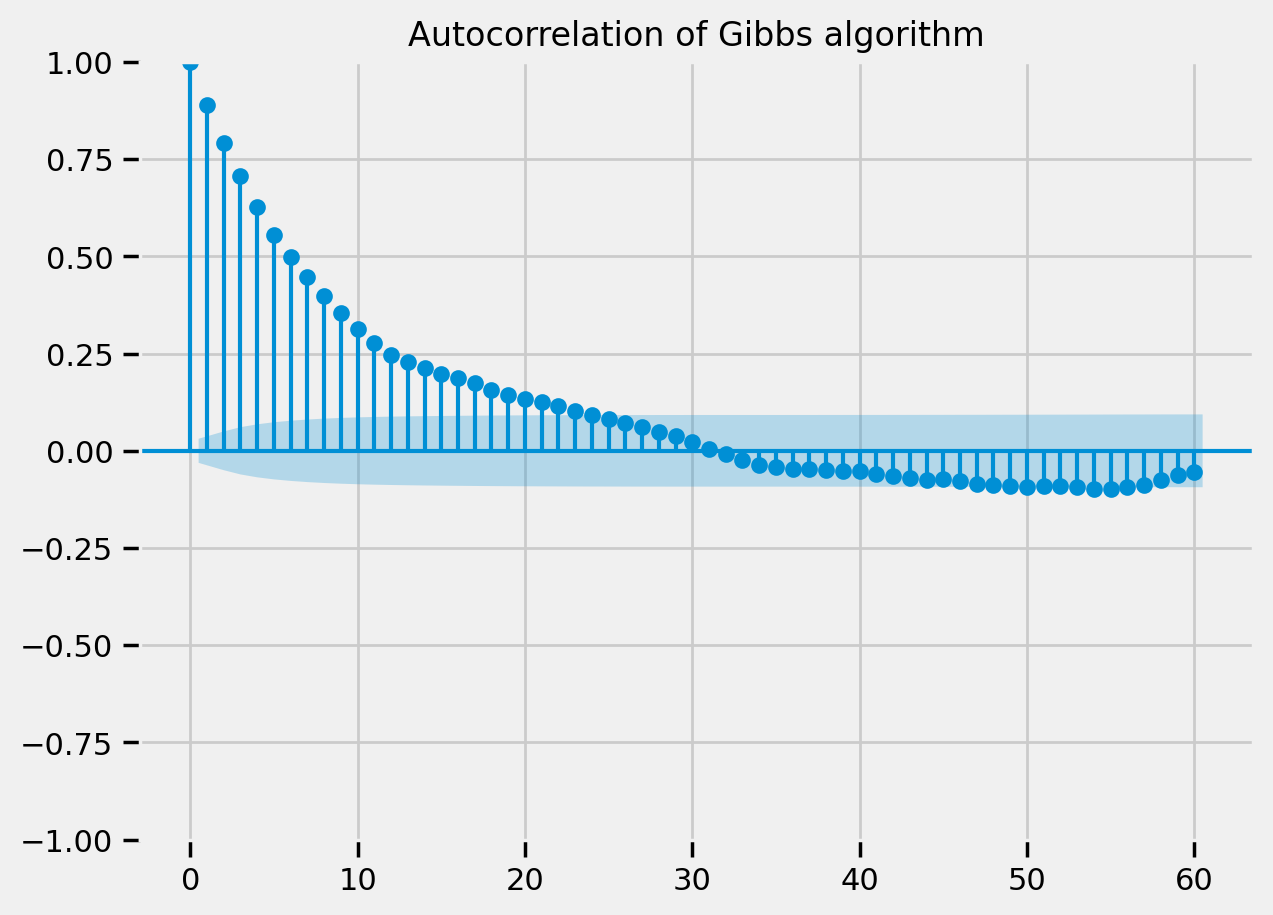

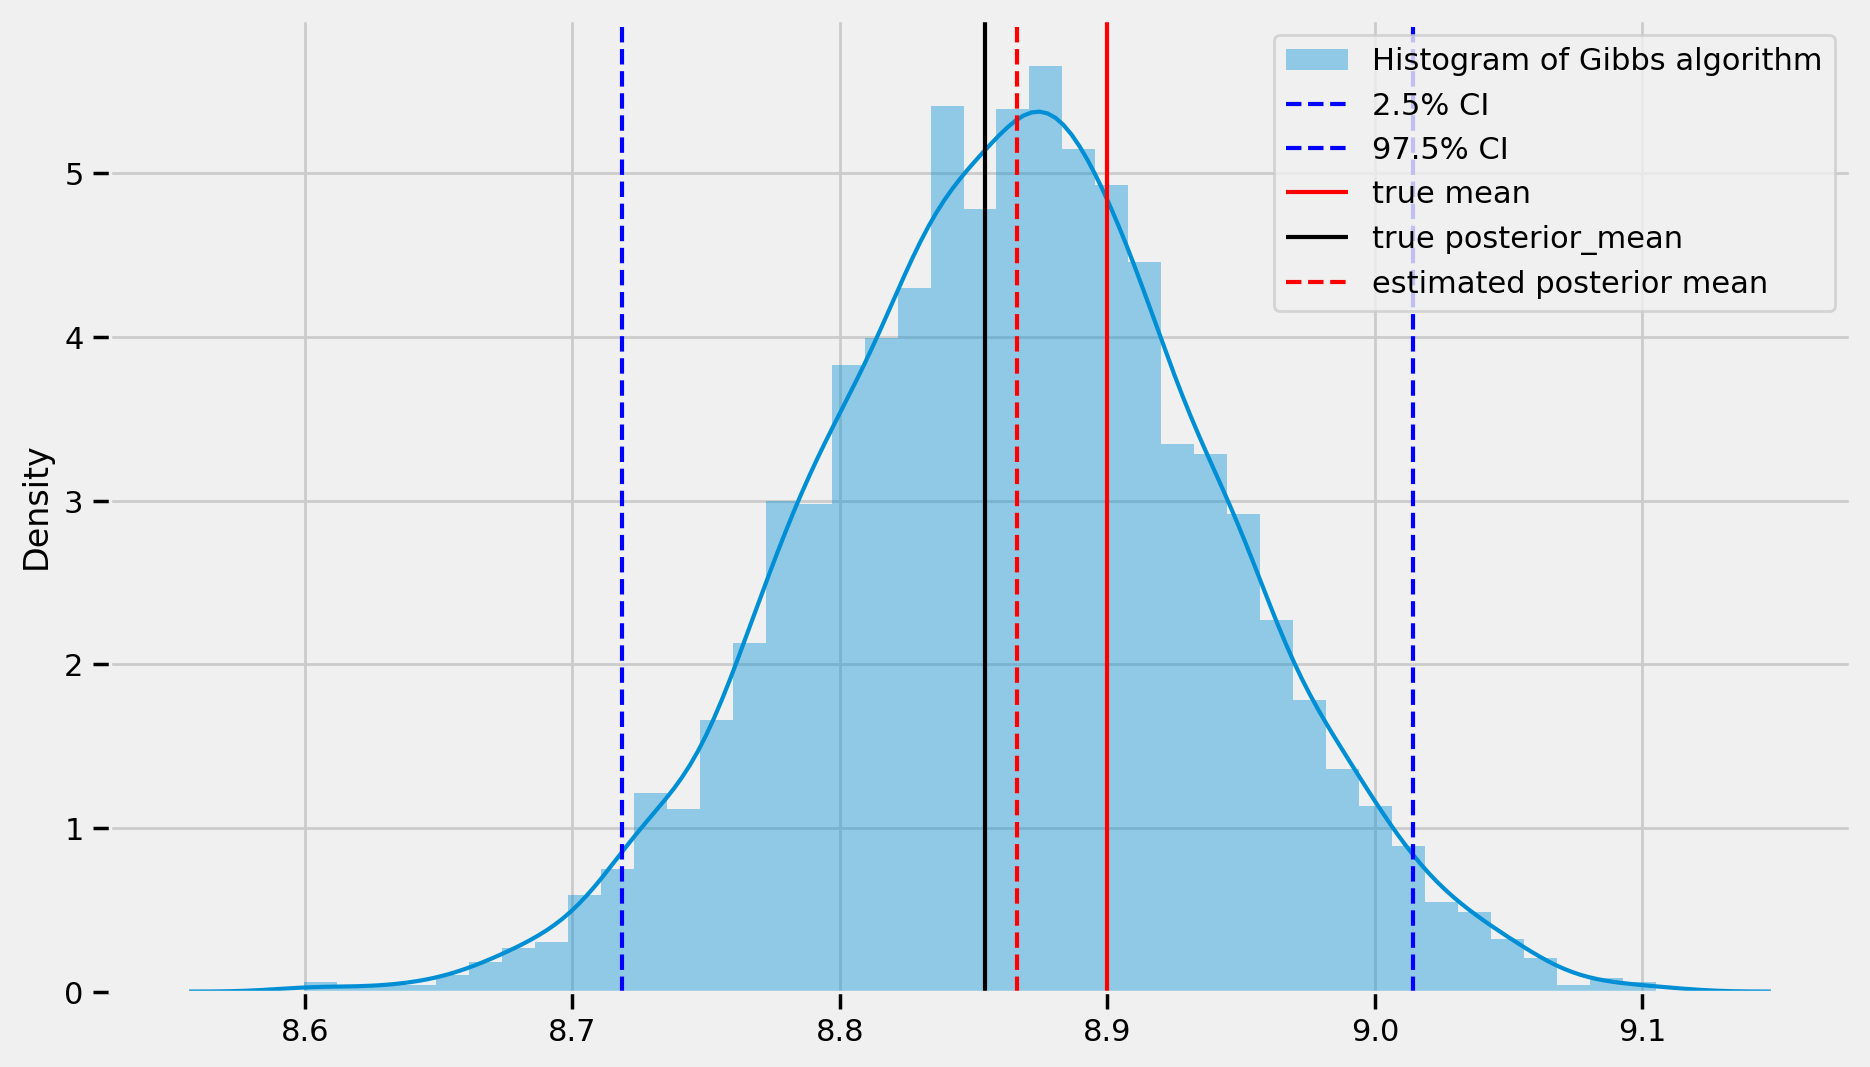

<ipython-input-9-6aa4a4788175>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


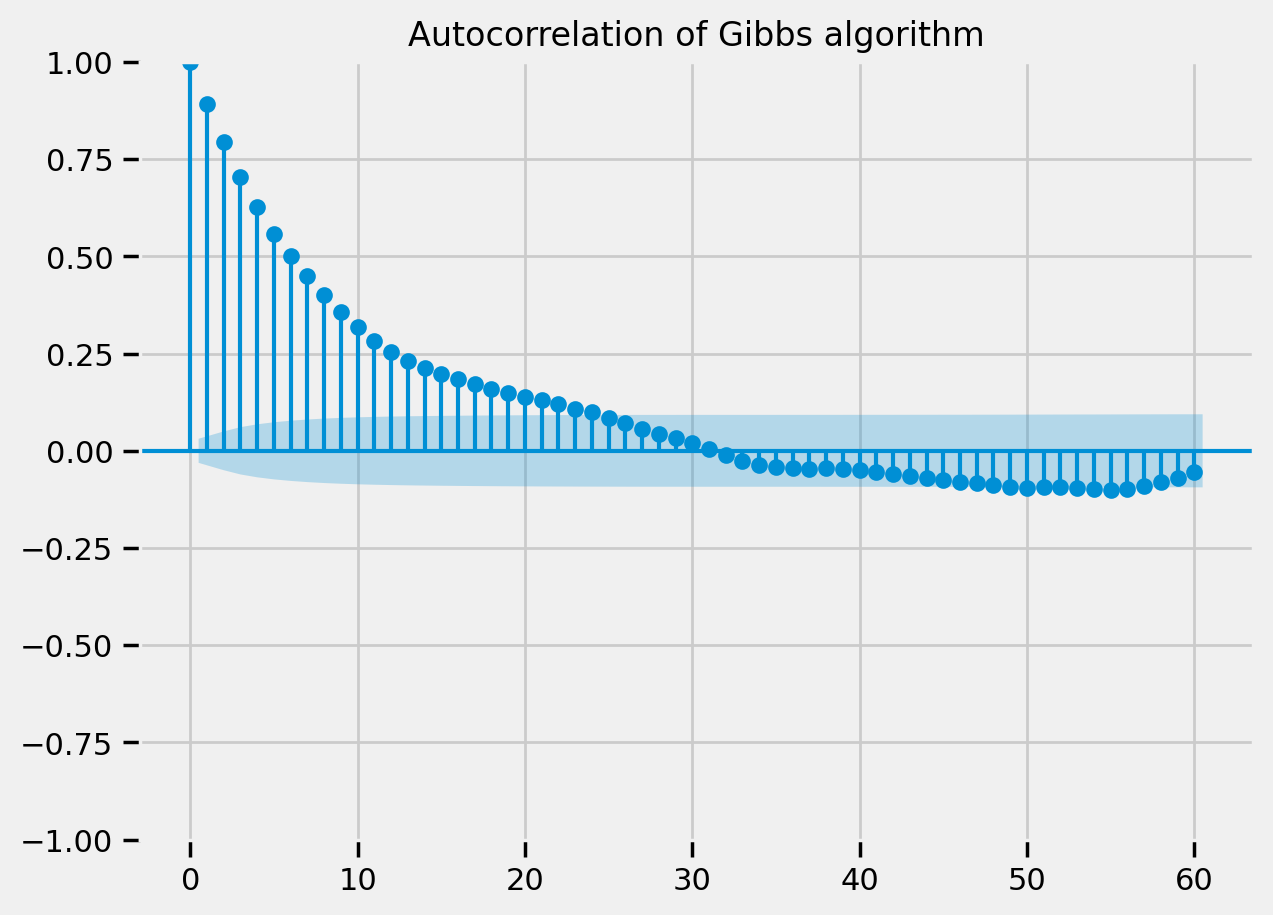

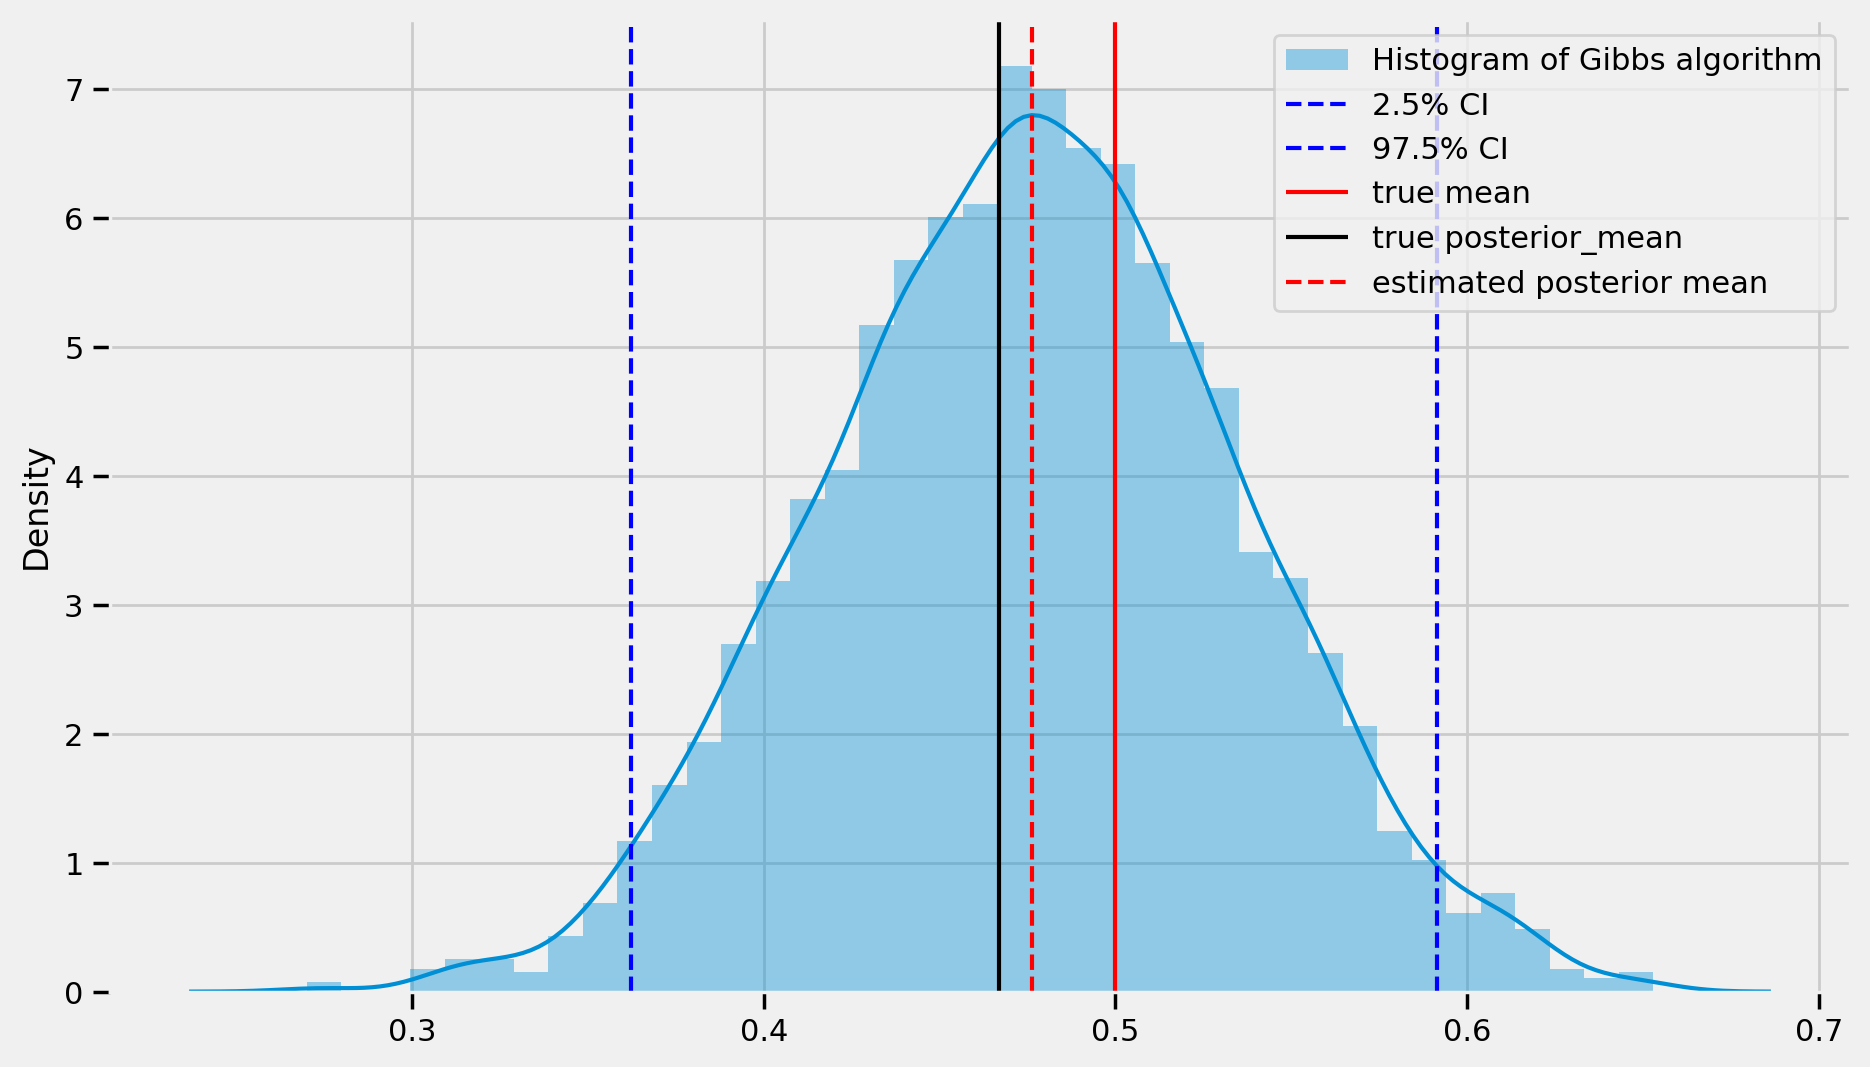

<ipython-input-9-6aa4a4788175>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


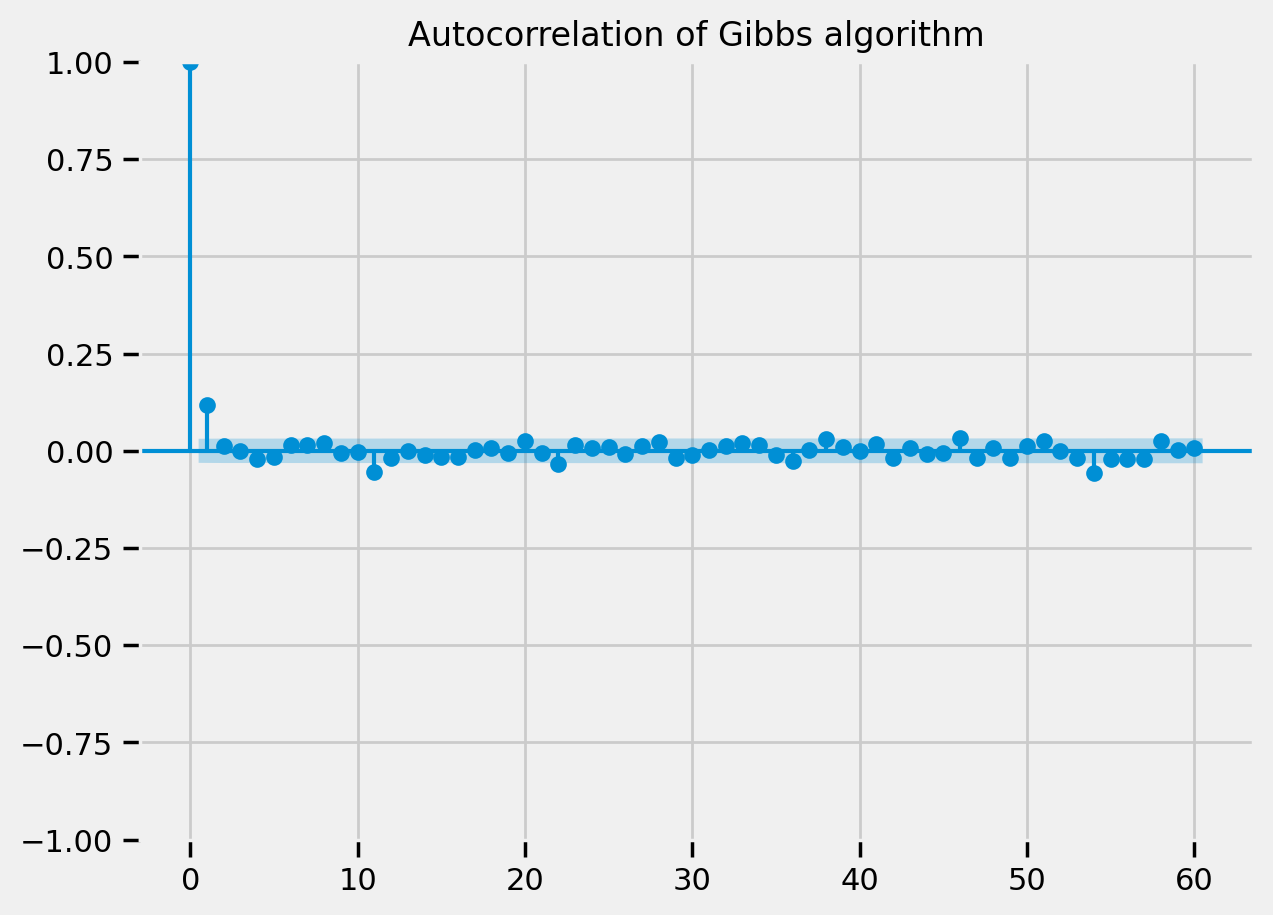

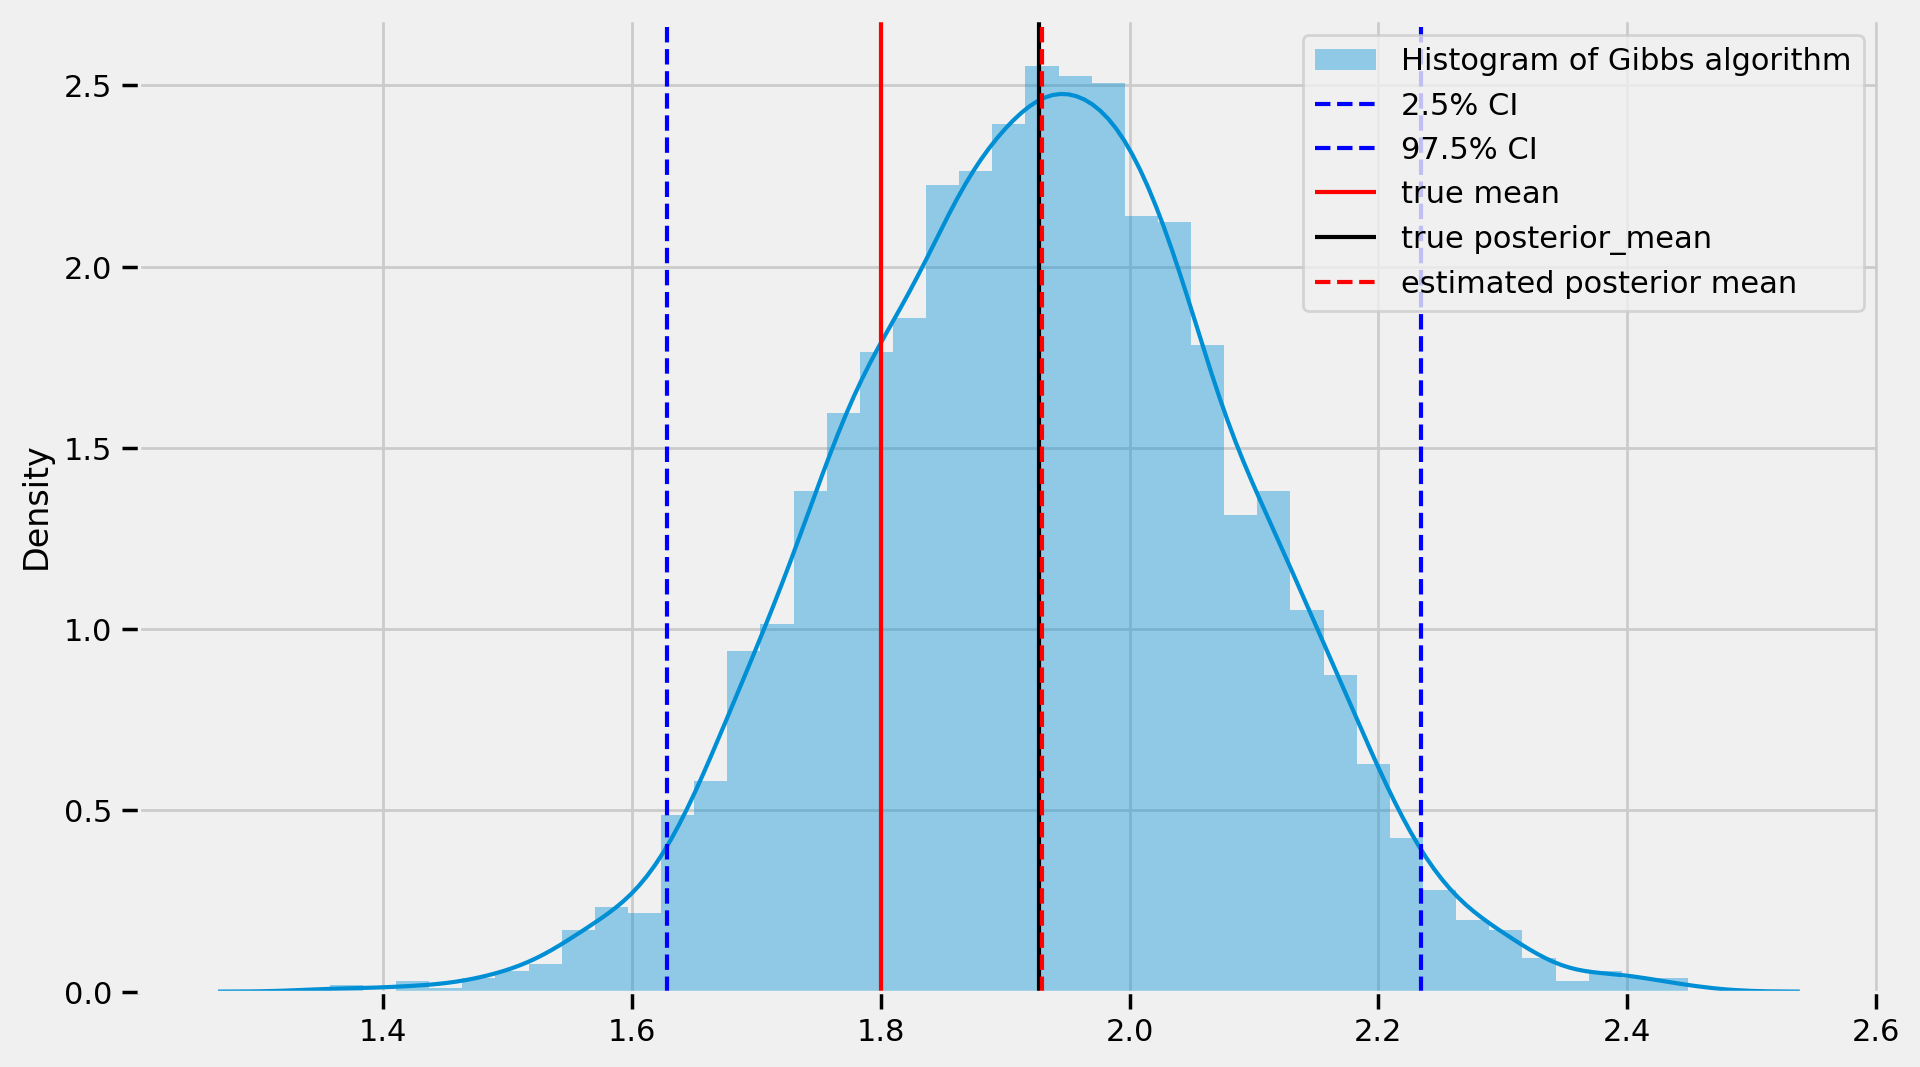

In [ ]:
# use the first chain for plotting auto-correlation
for kk  in range(signal_dim):

  inspect_mean = kk

  sm.graphics.tsa.plot_acf(gibbs_states[:, 0, inspect_mean],
                          title='Autocorrelation of Gibbs algorithm',
                          lags=60)

  # plot the fist chain

  mh_dist = gibbs_states[:, 0, inspect_mean]

  # Scatter plot of data samples and histogram
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(111)
  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')
  # lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
  ci_mh = credible_interval(mh_dist)
  ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
  ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
  ax.axvline(x=true_mean[inspect_mean], color='red', linestyle='-', label='true mean')
  ax.axvline(x=true_posterior_mean[inspect_mean], color='black', linestyle='-', label='true posterior_mean')
  ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

  ax.legend(loc="best")
  ax.grid(True, zorder=-5)
  plt.show()
